## 何をしでかしたか
- 今回の評価指標はRMSLE: sqrt(mean_squared_log_error)
- 全て0で埋めたsubをすると、sqrt(mean((log1p(y))^2))が返ってくる。
    - 今回は2.3799でした。
- 正解データを持つ`train`でsqrt(mean((log1p(y))^2))を計算すると
    - どうやら2.42くらい

## 前提
- PB/LBが半分ずつ(6004)でランダムに分けられている
- trainを半分ずつにランダムにサンプリングしsqrt(mean((log1p(y))^2))を計算。
  - これを20000回繰り返して「平均(正確には平均の2乗根)の分布」を計算。
  - 2乗外せばmean((log1p(y))^2)なので、平均の分布として見ることができそう
- train/testでmean(log1p(y))^2の分散は大体一緒
  - ここの分散も推定したいけど多分だいたい同じくらいだと俺のスタンドが告げている
- 中心極限定理を信じる

## 結果
- 中心極限定理によれば「標本平均の分布は大体正規分布になる」(この辺はググろう)  
- testに対してがないが、中心極限定理で平均と分散は大体わかる  
- trainよりもtestのほうが、全体の平均は小さめ。
- testは全体的に0が多いか、trainより高評価な作品が少ない？
  - これが分かると何がうれしいのかは不明。
  - `likes`が高い作品ばかりに気を取られると足元すくわれそう。
  - とはいえ予測値の最大値は見ておいて損はなさそう。
  - PBに関しては何も教えてくれないが、trainのランダムな分割の結果からは  
    そこまで大きく分布が乖離しているとは考えにくい
    - つまりshakeはあんまり起こらないのではないか。ごあんしんできそう。

## いつも応援してくれるみんなへ
- これを勝手に"metric hack"と読んでます。
  - コンペで色々コネコネして「平均」が出るようなタスクの場合、たまにLBの分布が推測できる場合がある
- 公開するか迷ったけど上の結果はどう使えるか微妙だし、
  - コンペの倫理的に公開しないほうが後悔しないかもしれない。これは私が背負う業である

In [1]:
### つかうやつ
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

In [2]:
# train
train = pd.read_csv('./input/train.csv')
train_likes = np.log1p(train['likes']) ** 2

In [3]:
# trainをランダムに2分割してみる
train_likes_LB = train_likes.sample(frac=0.5)
# print(len(train_likes_LB))
np.sqrt(np.mean(train_likes_LB))

2.4344823770103394

In [4]:
# trainでランダムサンプルを繰り返す。
mean_result = []
for i in range(20000):
    seed = random.randint(0, 999)
    train_likes_LB = train_likes.sample(frac=0.5)
    # print(np.sqrt(np.mean(train_likes_LB)))
    mean_result.append(np.mean(train_likes_LB))
mean_of_mean = np.mean(mean_result)
std_of_mean = np.std(mean_result)

log1p(y)の「平均の平均」: 5.888352112433509
log1p(y)の「平均の標準偏差」:0.09833101240310463


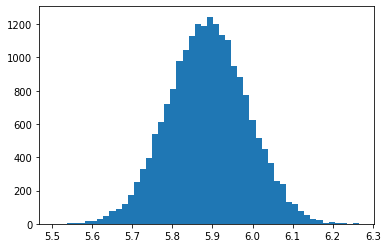

In [5]:
print(f'log1p(y)の「平均の平均」: {mean_of_mean}')
print(f'log1p(y)の「平均の標準偏差」:{std_of_mean}')
plt.hist(mean_result, bins=50)
plt.show()

In [6]:
# testは実際の値では計算できないので、
# all 0 subとtrainの分散で乱数生成
psuedo_test_dist = []
for i in range(20000):
    psuedo_test_dist.append(random.gauss(2.3799**2, std_of_mean))
psuedo_test_mean = np.mean(psuedo_test_dist)
psuedo_test_std = np.std(psuedo_test_dist)

testの平均の平均(の推計): 5.665214204051917
testの平均の標準偏差(の推計): 0.09750330400948537


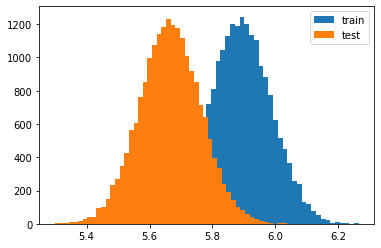

In [7]:
print(f'testの平均の平均(の推計): {psuedo_test_mean}')
print(f'testの平均の標準偏差(の推計): {psuedo_test_std}')

plt.hist(mean_result, bins=50, label='train')
plt.hist(psuedo_test_dist, bins=50, label='test')
plt.legend()
plt.show()

# なるほど……